In [1]:
import os
import sys
import  numpy as np
from tqdm import tqdm
# from data_prepare_old import *
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from torchvision import datasets, models, transforms

import collections
from torch import nn
from pathlib import Path
import PIL

base_path = "/data/lulei/classification"
sys.path.insert(0, base_path)
from tools.metrics import *
from tools.utils.utils import *
from tools.utils.model_zoo import MODELS
from tools.utils.torch_utils import *

import matplotlib.pyplot as plt

import warnings
# warnings.filterwarnings("ignore")


%run lib.ipynb

### 本脚本的目的

#### 1. top/bottom N classes 测试
1. 将训练集和测试集的图片均用于测试
2. 按照类别样本数的多少，取TOP-N和Bottom-N的类别用于测试

#### 2. 错误分类展示
1. 测试并展示错误分类

- 测试集和训练集地址

In [2]:
test_dir = "/data/lulei/data/vehicle/frontal_103/split/test"
valid_dir = "/data/lulei/data/vehicle/frontal_103/split/valid"

- 获取所有图片，并按样本数量的多少对所有类别进行排序

In [3]:
image_paths = [i for i in Path(test_dir).rglob("*.jpg") ] + [i for i in Path(valid_dir).rglob("*.jpg")]
print(f"[INFO] total image num : {len(image_paths):,}")

class_num = {}
for i in image_paths:
    label = i.parts[-2]
    if label in class_num:
        class_num[label] += 1
    else:
        class_num.update({label: 1})

class_num = sorted(class_num.items(), key = lambda kv:(kv[1], int(kv[0])), reverse = True)

print(f"[INFO] class num : {len(class_num):,}")

[INFO] total image num : 32,711
[INFO] class num : 1,759


- 获取TOP-N和Bottom-N类别

In [4]:
N = 20

In [5]:
top_n_classes = [i[0] for i in class_num[:N]]
bot_n_classes = [i[0] for i in class_num[-N:]]

top_n_images = [ i for i in image_paths if i.parts[-2] in top_n_classes]
bot_n_images = [ i for i in image_paths if i.parts[-2] in bot_n_classes]

# print(top_n_classes)
# print(bot_n_classes)

print(f"[INFO] top {N} classes, image num : {len(top_n_images)}")
print(f"[INFO] bot {N} classes, image num : {len(bot_n_images)}")

[INFO] top 20 classes, image num : 2632
[INFO] bot 20 classes, image num : 80


- 选择并加载神经网络模型

In [6]:
weight_files = [i for i in pathlib.Path("./output_models").rglob("*.pth")]
print(f"[INFO] weight files : ")

for index, weight_file in enumerate(weight_files):
    print(f"  [{index}] {weight_file.name}")
weight_file = weight_files[int(input("  your choice : "))]

network = os.path.basename(weight_file).split("_")[1]

# networks = ["alexnet", "densenet121", "resnet18", "resnet34", "resnet50", "vgg16", "vgg19"]

model_struc = eval(f"MODELS(class_num = 1759, with_wts = False).{network}()")
model = load_model_from_wts(model_struc, weight_file, gpu_id = [0,1])

[INFO] weight files : 
  [0] vehicle_resnet50_0.9182_49_best_20191224_142352.pth
  [1] vehicle_resnet18_0.9017_26_best_20191224_124247.pth
  [2] vehicle_densenet121_0.9182_40_best_20191224_113211.pth
  [3] vehicle_alexnet_0.8711_33_best_20191223_234904.pth
  [4] vehicle_vgg16_0.9128_30_best_20191224_173140.pth
  [5] vehicle_vgg19_0.9190_24_best_20191224_204329.pth


  your choice :  3


3


In [7]:
y_true, y_pred = batch_predict(model, top_n_images, per_group_num = 100)
performance(y_true, y_pred, title = "TOP-N")

100%|██████████| 27/27 [00:05<00:00,  5.31it/s]

TOP-N performance : 
  overall acc     : 0.9290
  mean acc        : 0.9958
  overall prec    : 0.9290
  mean prec       : 0.9856
  mean recall     : 0.9362


In [8]:
y_true, y_pred = batch_predict(model, bot_n_images, per_group_num = 2)
performance(y_true, y_pred, title = "BOT-N")

100%|██████████| 40/40 [00:01<00:00, 21.47it/s]

BOT-N performance : 
  overall acc     : 0.7875
  mean acc        : 0.9894
  overall prec    : 0.7875
  mean prec       : 1.0000
  mean recall     : 0.7875


- 随机选择一张图片用作测试
- 输出top-N 预测结果
- 可视化top-N的概率与预测结果

In [9]:
N = 5

In [10]:
image_path = image_paths[1]
y_true, top_n_results = predict(model, image_path, top = N)

In [11]:
base_color = "cornflowerblue"
right_color = "tomato"

x_axis_prob = [prob for prob, label in top_n_results]
y_axis = [i for i in range(N)]

color = [base_color if label != y_true else right_color for prob, label in top_n_results]

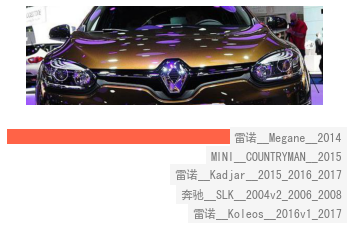

In [12]:
figure, ax=plt.subplots(2,1)

ax[0].axis("off")
ax[0].imshow(Image.open(image_path))

plt.barh(y_axis, x_axis_prob[::-1], color = color[::-1])
plt.xlim(0 , 1)
plt.yticks([])
plt.axis("off")

for index, (prob, label) in enumerate(top_n_results):
    plt.text(1, N - index -1, label_to_classname[str(label)], ha='right', va= 'center', \
             fontsize=12, alpha = 0.5, backgroundcolor = "whitesmoke")

In [13]:
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimSun']
mpl.rcParams['font.serif'] = ['SimSun']

In [14]:
top_n_results

[[1.0, '1717'], [0.0, '51'], [0.0, '1705'], [0.0, '794'], [0.0, '1709']]

In [48]:
def centralize(img, l_ratio, r_ratio, up_ratio, down_ratio):
    
    iw, ih = img.size
    center_x = iw // 2
    center_y = ih // 2

    # 上下左右缩进的尺寸,相对于宽度和高度
    rw = int(r_ratio * iw)
    lw = int(l_ratio * iw)
    up_h = int(up_ratio * ih)
    down_h = int(down_ratio * ih)

    new_img= img.crop(
     (
        lw ,
        up_h,
        iw - rw,
        ih - down_h
    )
    )
    return new_img

In [65]:
image = Image.open(image_path)

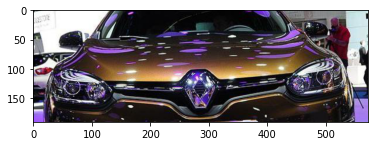

In [66]:
plt.imshow(image, cmap = "gray")

In [67]:
img = centralize(image, 0.1, 0.1, 0.1, 0.5)

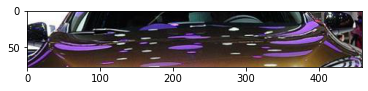

In [68]:
plt.imshow(img)